In [491]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import _LRScheduler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import random


In [492]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


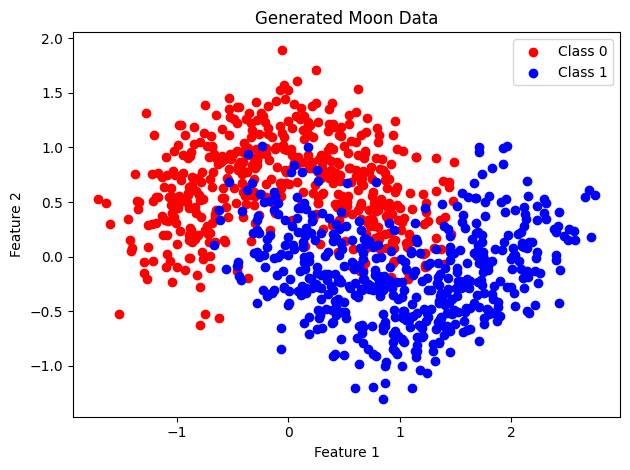

In [493]:
# Generate the dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=32)

# Plot the dataset
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', marker='o', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', marker='o', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper right')
plt.title('Generated Moon Data')
plt.tight_layout()
plt.show()

In [494]:
def evaluate(model, dataloader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_preds += targets.size(0)
            correct_preds += (predicted == targets).sum().item()

    accuracy = (correct_preds / total_preds) * 100
    return accuracy

In [495]:
def train(model, optimizer, criterion, dataloader, val_dataloader):
    model.train()
    total_loss = 0.0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.float())
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)

    return average_loss, average_val_loss


In [496]:
def train_model(model, optimizer, criterion, dataloader, val_dataloader, lr_scheduler = None, num_epochs=100):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss, val_loss = train(model, optimizer, criterion, dataloader, val_dataloader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracy = evaluate(model, val_dataloader)
        val_accuracies.append(val_accuracy)

        if lr_scheduler is not None:
            lr_scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            if lr_scheduler:
                print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, LR: {lr_scheduler.get_last_lr()[0]:.6f}")
            else:
                print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies

In [497]:
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate = 0.3):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        
        init.zeros_(self.fc1.bias)
        init.zeros_(self.fc2.bias)
        init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x.squeeze()


In [498]:
def plotcost(train_losses, val_losses, title):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs of {title}')
    plt.legend()
    plt.show()

$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$

In [499]:
class CustomLRDecay(_LRScheduler):
    def __init__(self, optimizer, decay_rate, time_interval, last_epoch=-1):
        self.decay_rate = decay_rate
        self.time_interval = time_interval
        super(CustomLRDecay, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr / (1.0 + self.decay_rate * (self.last_epoch // self.time_interval))
                for base_lr in self.base_lrs]

In [500]:
y = y.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


learning_rate = 0.001
num_epochs = 500
time_interval = 100
decay_rate = 1
momentum = 0.9

criterion = nn.BCEWithLogitsLoss()

Epoch: 10/500, Train Loss: 0.3264, Val Loss: 0.2872, Val Acc: 86.00%
Epoch: 20/500, Train Loss: 0.3061, Val Loss: 0.2764, Val Acc: 87.00%
Epoch: 30/500, Train Loss: 0.3038, Val Loss: 0.2647, Val Acc: 87.00%
Epoch: 40/500, Train Loss: 0.2806, Val Loss: 0.2547, Val Acc: 87.00%
Epoch: 50/500, Train Loss: 0.2674, Val Loss: 0.2534, Val Acc: 87.50%
Epoch: 60/500, Train Loss: 0.2728, Val Loss: 0.2484, Val Acc: 86.50%
Epoch: 70/500, Train Loss: 0.2629, Val Loss: 0.2420, Val Acc: 88.50%
Epoch: 80/500, Train Loss: 0.2467, Val Loss: 0.2397, Val Acc: 88.00%
Epoch: 90/500, Train Loss: 0.2406, Val Loss: 0.2343, Val Acc: 87.50%
Epoch: 100/500, Train Loss: 0.2309, Val Loss: 0.2318, Val Acc: 88.50%
Epoch: 110/500, Train Loss: 0.2329, Val Loss: 0.2341, Val Acc: 88.00%
Epoch: 120/500, Train Loss: 0.2229, Val Loss: 0.2300, Val Acc: 87.50%
Epoch: 130/500, Train Loss: 0.2219, Val Loss: 0.2286, Val Acc: 87.00%
Epoch: 140/500, Train Loss: 0.2242, Val Loss: 0.2277, Val Acc: 88.50%
Epoch: 150/500, Train Loss: 0

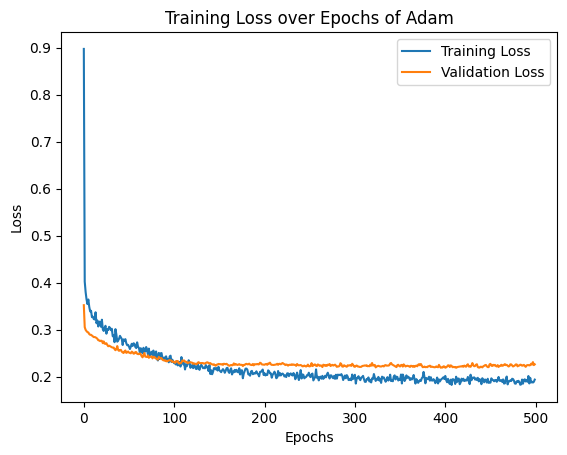

In [501]:
model1 = SimpleNN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

Adam_train_losses, Adam_val_losses, Adam_val_accuracies = train_model(model1, optimizer1, criterion, dataloader, val_dataloader, num_epochs=num_epochs)

plotcost(Adam_train_losses, Adam_val_losses, 'Adam')

Epoch: 10/500, Train Loss: 0.3853, Val Loss: 0.3107, Val Acc: 83.50%
Epoch: 20/500, Train Loss: 0.3588, Val Loss: 0.3033, Val Acc: 85.00%
Epoch: 30/500, Train Loss: 0.3361, Val Loss: 0.2996, Val Acc: 85.00%
Epoch: 40/500, Train Loss: 0.3594, Val Loss: 0.2970, Val Acc: 85.00%
Epoch: 50/500, Train Loss: 0.3508, Val Loss: 0.2956, Val Acc: 85.50%
Epoch: 60/500, Train Loss: 0.3365, Val Loss: 0.2938, Val Acc: 85.50%
Epoch: 70/500, Train Loss: 0.3338, Val Loss: 0.2917, Val Acc: 86.00%
Epoch: 80/500, Train Loss: 0.3529, Val Loss: 0.2911, Val Acc: 86.00%
Epoch: 90/500, Train Loss: 0.3367, Val Loss: 0.2919, Val Acc: 86.00%
Epoch: 100/500, Train Loss: 0.3372, Val Loss: 0.2911, Val Acc: 86.50%
Epoch: 110/500, Train Loss: 0.3244, Val Loss: 0.2905, Val Acc: 86.00%
Epoch: 120/500, Train Loss: 0.3252, Val Loss: 0.2899, Val Acc: 86.00%
Epoch: 130/500, Train Loss: 0.3221, Val Loss: 0.2884, Val Acc: 86.00%
Epoch: 140/500, Train Loss: 0.3228, Val Loss: 0.2878, Val Acc: 85.50%
Epoch: 150/500, Train Loss: 0

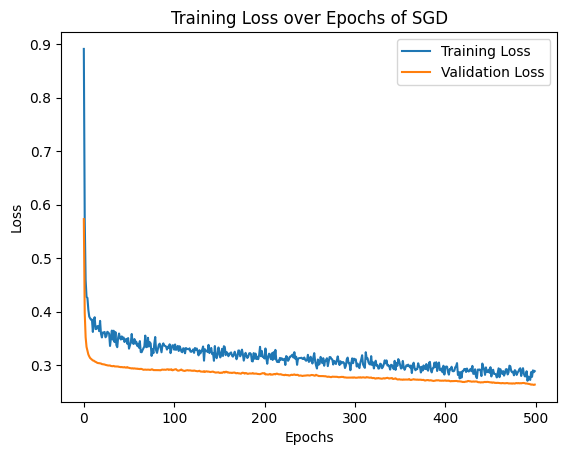

In [502]:
model2 = SimpleNN().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate, momentum=momentum)  

SGD_train_losses, SGD_val_losses, SGD_val_accuracies = train_model(model2, optimizer2, criterion, dataloader, val_dataloader, num_epochs=num_epochs)

plotcost(SGD_train_losses, SGD_val_losses, 'SGD')

Epoch: 10/500, Train Loss: 0.2837, Val Loss: 0.2553, Val Acc: 86.50%, LR: 0.005000
Epoch: 20/500, Train Loss: 0.2637, Val Loss: 0.2441, Val Acc: 86.50%, LR: 0.005000
Epoch: 30/500, Train Loss: 0.2238, Val Loss: 0.2285, Val Acc: 87.50%, LR: 0.005000
Epoch: 40/500, Train Loss: 0.2218, Val Loss: 0.2280, Val Acc: 88.50%, LR: 0.005000
Epoch: 50/500, Train Loss: 0.2151, Val Loss: 0.2345, Val Acc: 88.00%, LR: 0.005000
Epoch: 60/500, Train Loss: 0.2061, Val Loss: 0.2234, Val Acc: 88.50%, LR: 0.005000
Epoch: 70/500, Train Loss: 0.2052, Val Loss: 0.2178, Val Acc: 88.00%, LR: 0.005000
Epoch: 80/500, Train Loss: 0.2010, Val Loss: 0.2227, Val Acc: 88.50%, LR: 0.005000
Epoch: 90/500, Train Loss: 0.1946, Val Loss: 0.2190, Val Acc: 88.50%, LR: 0.005000
Epoch: 100/500, Train Loss: 0.2049, Val Loss: 0.2236, Val Acc: 88.00%, LR: 0.002500
Epoch: 110/500, Train Loss: 0.1939, Val Loss: 0.2179, Val Acc: 89.00%, LR: 0.002500
Epoch: 120/500, Train Loss: 0.1915, Val Loss: 0.2202, Val Acc: 88.50%, LR: 0.002500
E

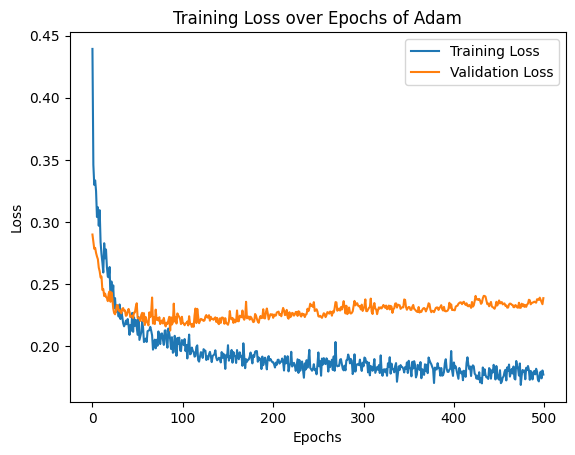

In [503]:
model3 = SimpleNN().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate*5)
scheduler1 = CustomLRDecay(optimizer3, decay_rate=decay_rate, time_interval=time_interval) 

Adamlr_train_losses, Adamlr_val_losses, Adamlr_val_accuracies = train_model(model3, optimizer3, criterion, dataloader, val_dataloader, lr_scheduler=scheduler1, num_epochs=num_epochs)

plotcost(Adamlr_train_losses, Adamlr_val_losses, 'Adam')

Epoch: 10/500, Train Loss: 0.3457, Val Loss: 0.3004, Val Acc: 85.50%, LR: 0.005000
Epoch: 20/500, Train Loss: 0.3361, Val Loss: 0.2909, Val Acc: 86.00%, LR: 0.005000
Epoch: 30/500, Train Loss: 0.3220, Val Loss: 0.2857, Val Acc: 87.00%, LR: 0.005000
Epoch: 40/500, Train Loss: 0.3212, Val Loss: 0.2794, Val Acc: 86.00%, LR: 0.005000
Epoch: 50/500, Train Loss: 0.3087, Val Loss: 0.2775, Val Acc: 86.00%, LR: 0.005000
Epoch: 60/500, Train Loss: 0.3085, Val Loss: 0.2719, Val Acc: 85.50%, LR: 0.005000
Epoch: 70/500, Train Loss: 0.3038, Val Loss: 0.2671, Val Acc: 87.00%, LR: 0.005000
Epoch: 80/500, Train Loss: 0.2999, Val Loss: 0.2628, Val Acc: 87.00%, LR: 0.005000
Epoch: 90/500, Train Loss: 0.2846, Val Loss: 0.2555, Val Acc: 88.00%, LR: 0.005000
Epoch: 100/500, Train Loss: 0.2763, Val Loss: 0.2533, Val Acc: 87.50%, LR: 0.002500
Epoch: 110/500, Train Loss: 0.2806, Val Loss: 0.2484, Val Acc: 87.50%, LR: 0.002500
Epoch: 120/500, Train Loss: 0.2688, Val Loss: 0.2462, Val Acc: 87.00%, LR: 0.002500
E

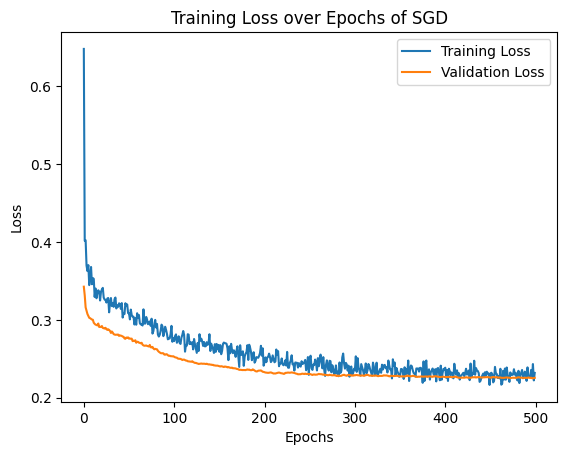

In [504]:
model4 = SimpleNN().to(device)
optimizer4 = optim.SGD(model4.parameters(), lr=learning_rate*5, momentum=momentum)
scheduler2 = CustomLRDecay(optimizer4, decay_rate=decay_rate, time_interval=time_interval)  

SGDlr_train_losses, SGDlr_val_losses, SGDlr_val_accuracies = train_model(model4, optimizer4, criterion, dataloader, val_dataloader, lr_scheduler=scheduler2, num_epochs=num_epochs)

plotcost(SGDlr_train_losses, SGDlr_val_losses, 'SGD')

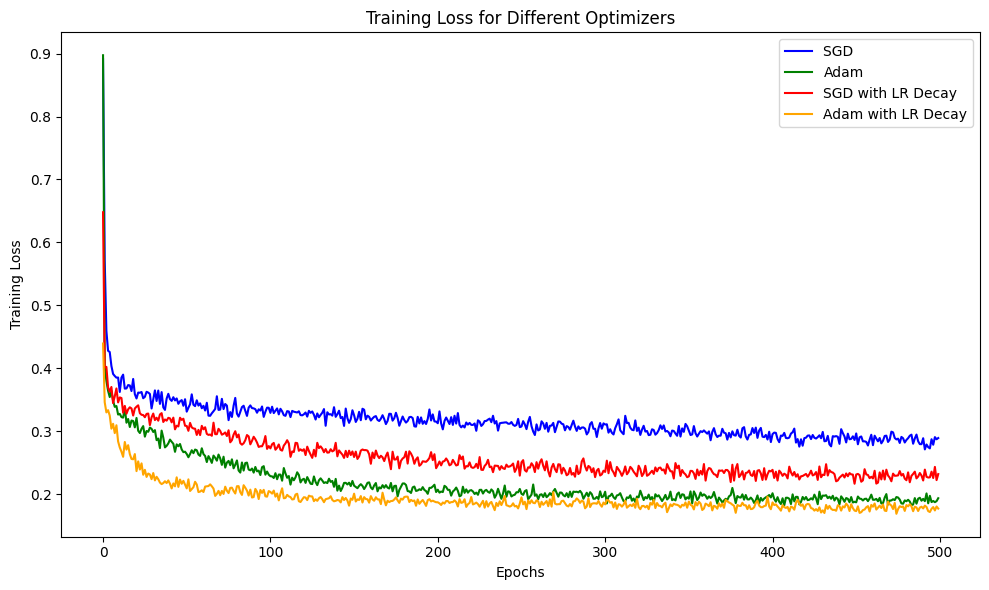

In [505]:
plt.figure(figsize=(10, 6))

plt.plot(SGD_train_losses, label='SGD ', color='blue')
plt.plot(Adam_train_losses, label='Adam', color='green')
plt.plot(SGDlr_train_losses , label='SGD with LR Decay', color='red')
plt.plot(Adamlr_train_losses, label='Adam with LR Decay', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Optimizers')
plt.legend()

plt.tight_layout()
plt.show()

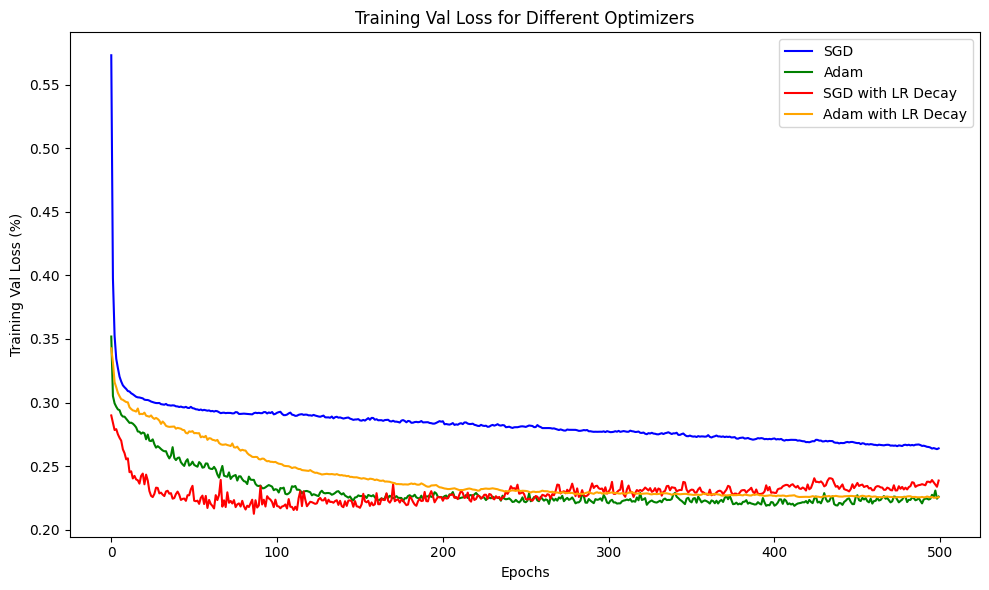

In [506]:
# Plotting Accuracies for Different Optimizers
plt.figure(figsize=(10, 6))

plt.plot(SGD_val_losses, label='SGD', color='blue')
plt.plot(Adam_val_losses, label='Adam', color='green')
plt.plot(Adamlr_val_losses, label='SGD with LR Decay', color='red')
plt.plot(SGDlr_val_losses, label='Adam with LR Decay', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Training Val Loss (%)')
plt.title('Training Val Loss for Different Optimizers')
plt.legend()

plt.tight_layout()
plt.show()

In [507]:
# Calculate average accuracy over last 10 epochs for each optimizer
last_10_epochs = 10
avg_Adam_accuracy = np.mean(Adam_val_accuracies[-last_10_epochs:])
avg_SGD_accuracy = np.mean(SGD_val_accuracies[-last_10_epochs:])
avg_Adamlr_accuracy = np.mean(Adamlr_val_accuracies[-last_10_epochs:])
avg_SGDlr_accuracy = np.mean(SGDlr_val_accuracies[-last_10_epochs:])

# Store accuracies in a dictionary
accuracies = {
    'Adam': avg_Adam_accuracy,
    'SGD': avg_SGD_accuracy,
    'Adam with LR Decay': avg_Adamlr_accuracy,
    'SGD with LR Decay': avg_SGDlr_accuracy
}

# Print the accuracies in a table format
print("Optimizer".ljust(20), "Average Accuracy (%)".rjust(25))
print("-"*45)
for opt_name, accuracy in accuracies.items():
    print(opt_name.ljust(20), f"{accuracy:.2f}".rjust(25))

Optimizer                 Average Accuracy (%)
---------------------------------------------
Adam                                     88.85
SGD                                      87.00
Adam with LR Decay                       88.10
SGD with LR Decay                        89.35
